# Agent-Based Modeling of the Cooperation among Schools Under Population Decline Using Python MESA
Daeil Chun, 2022-02-22

### Introduction
The agents in this model represent the colleges in a region where population declines, e.g. as in Korea. Government and public opinion recommend each school to restructure their business operation either by reducing the number of entering students or merging with other schools. They recommend this because a sudden closure of schools increases some social costs on job market, land use efficiency and student welfares. However, regardless of public recommendation, the schools, who are free agents, can stick to their current business operation, hoping they can sustain themselves with the remaining students after other schools exit the market. So, each school is modeled either to cooperate to the policy recommendation or defect it.



### A Chicken Game
Although the strategy profile, i.e. cooperate or defect, sounds like Prisoner's Dilema game, the payoff structure of this game is similar to Chicken game as Table 1.

Talbe 1. The Payoff Matrix of the Game
<table>
    <tr><td></td><td>Cooperate</td><td>Defect</td></tr>
    <tr><td>Cooperate</td><td>1,1</td><td>0.5, 1.5</td></tr>
    <tr><td>Defect</td><td>1.5, 0.5</td><td>-1, -1</td></tr>
</table>

- If all players cooperate, they can share the market, i.e. the college applicants, without any extra cost.
- If all players defect, all would get a severe penalty due to the population decline.
- If one player defect while others don't, the defecting agent can gain more due to one's competitve marketing. Then, cooperating agents would lose some students.

The reason to adopt Chicken game is that the population decline will damage all parties if all ignore it.

To make the payoff matrix dynamic, I will apply the concept of a portion, which is the number of population divided by the number of schools, to each cell in the Table 1. 

Talbe 2. The Payoff to each player of the Game (identical to all)
<table>
    <tr><td></td><td>Cooperate</td><td>Defect</td></tr>
    <tr><td>Cooperate</td><td>1 portion</td><td>0.5 portion</td></tr>
    <tr><td>Defect</td><td>1.5 portion</td><td>-1 portion</td></tr>
</table>

The portion will decrease every step of the simulation, so that the outcome of the early stage would have a stronger implication than those of later stages in general. (TBD: However, the portion can also increase when some schools go bankrupt.)

### 3 types of Decision Making Rules
Although the payoff matrix is identical to all, the agents differ in decision making types:
1. Rational Practice : get the neighbor's cooperation history, and decide the move that yields the higher expected outcome. 
2. Mimic Best Practice : imitate the neighbor with the best score.
3. Mimic Average Practice : imitate the most common action among the neighboring players

The simulation is not interested in finding Nash equilibrium because the real world institutions may not play by the same degree of rationality, and many of them would simply imitate other public institutions.

Users can set the proportion of these 3 types of agents in the game.

### Other Assumptions
- Score Accumulation: players begin with different scores, and the payoff from each stem will be added to one's own score
- Simulteneous game: all decide next moves without knowing what others choose
- Torodial space: Agents at the border of the grid decide their neighbors as the Pacman game
- Neighbor: a kind of strategic distance. It can mean regional comeititon or special major competition. For example, competition among medical schools are not much associated with physical distance. 
- One strategy for all neighbor: the school's choice of restructuring is not alterable in any given step, though possilbe in next step. So, each agent plays with the neighbors by the same stratgy chosen.


### How the Game Proceed
0. Each school will take one of the three decision making rules by model parameter
1. Each school begins with an initial score randomly chosen from a range (e.g. between 0 to 20).
2. Each school scans the 8 neighbors' moves and accumulated scores
3. Each school decides one's next move by one's own decision making rule.
4. Advance to the next step with the chosen move.
5. Play the game with all 8 neighbors, and sum up all the payoffs to add on one's own score.
6. Repeat the 2 ~ 5 in every step
7. If an agent has the current score in negative, it goes bankrupt, and any game involved with that agent will be void giving zero.



#### Codes

The following code is for rendering the result in the notebook. For the actual abm codes, see agent.py and model.py in the schools_pd directory.

In [1]:
from schools_pd.model import SchoolsPd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
bwr = plt.get_cmap("bwr")

def draw_grid(model, ax=None):
    '''
    Draw the current state of the grid, with Defecting agents in red,
    Cooperating in blue and Bankrupt in grey.
    '''
    if not ax:
        fig, ax = plt.subplots(figsize=(6,6))
    grid = np.zeros((model.grid.width, model.grid.height))
    for agent, x, y in model.grid.coord_iter():
        if agent.score < 0:
            grid[y][x] = 0.5
        elif agent.move == "D":
            grid[y][x] = 1
        else:
            grid[y][x] = 0
    ax.pcolormesh(grid, cmap=bwr, vmin=0, vmax=1)
    ax.axis('off')
    ax.set_title("Steps: {}".format(model.schedule.steps))

In [3]:
def run_model(model):
    '''
    Run an experiment with a given model, and plot the results.
    '''
    fig = plt.figure(figsize=(12,12))
    
    for i in range(1,10):
        ax = fig.add_subplot(3,3, i)
        draw_grid(model, ax)
        model.run(2) # Will show the result of every step. Modify the step number accordingly

    model.datacollector.get_model_vars_dataframe().plot(style={'Cooperating Schools': 'blue', 'Defecting Schools': 'red', 'Bankrupt Schools': 'grey'})

###  A Sample Simulation - Rational Player 30%, Mimic the Best 35% and Mimic the Average 35% 
The world is a mix of all different type of decision makers. Let's first run with the initial cooperation level at 1%.

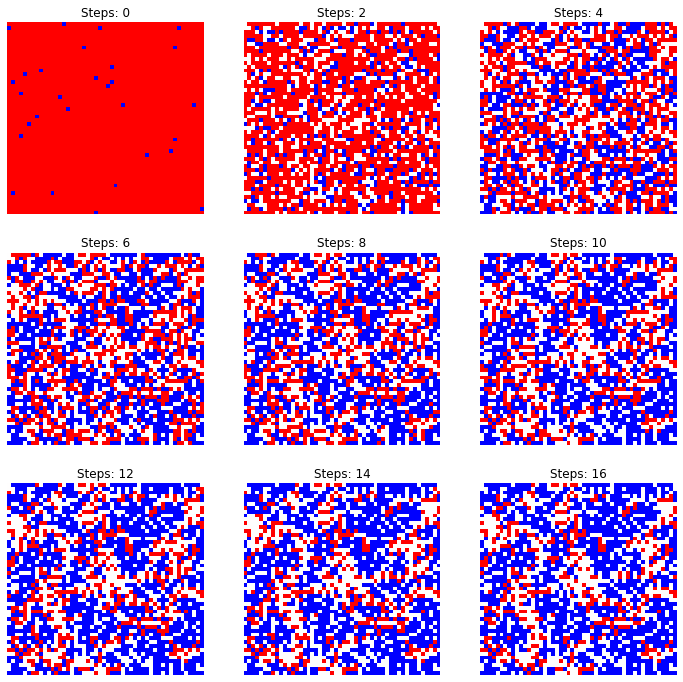

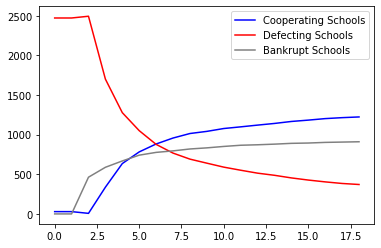

In [4]:
# Set the model parameters 
ppl = 1000          # The initial population
ppl_change = -0.01  # Decline 1% every step
payoff_coeff = [1, -0.5, 1.5, -1]    # Chicken Game matrix
init_score_min = 0     # The lower boundery for agent's initial score
init_score_max = 20    # The upper boundery for agent's initial score
init_coop = 0.01 # the 1% of cooperating schools at step 0
init_rp = 0.3   # the proportion of rational player is zero
init_bp = 0.5   # the proportion of the best practice imitator among the non-rational player

# run the mobel
m = SchoolsPd(height=50, width=50, ppl=ppl, ppl_change=ppl_change, payoff_coeff=payoff_coeff, init_score_min=init_score_min, init_score_max=init_score_max, init_rp=init_rp, init_coop=init_coop, init_bp=init_bp)
run_model(m)

This is one of many possible future. Let's run this many times to get some stats.

##### Batch Simulation 1 - All Mimic the Best

In [10]:
# modify the params of interest
init_rp=0
init_bp=1


def batch_model(nsim, laststep):
    '''
    Run several experiments with a given model, and plot the results.
    '''
    outcome =[]
    for i in range(0, nsim):
        m = SchoolsPd(height=50, width=50, ppl=ppl, ppl_change=ppl_change, payoff_coeff=payoff_coeff, init_score_min=init_score_min, init_score_max=init_score_max, init_rp=init_rp, init_coop=init_coop, init_bp=init_bp)
        m.run(laststep)
        outcome.append(m.datacollector.get_model_vars_dataframe()['Bankrupt Schools'].iloc[-1])
    return(outcome)


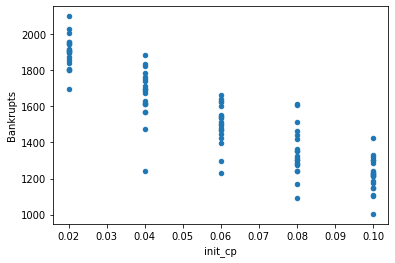

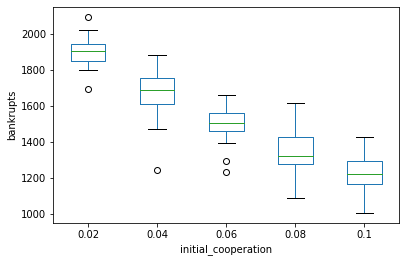

In [11]:
import pandas as pd

df = pd.DataFrame(columns=["init_cp", "Bankrupts"])

for i in range(1,6):
    init_coop = i/50
    bankrupts=batch_model(nsim=20, laststep=20)
    for item in bankrupts:
        df = df.append({"init_cp":init_coop, 'Bankrupts': item}, ignore_index=True)

#For further analysis, make a file.
#df.to_csv("abm_batch_running.csv")

#scatter plot
df.plot.scatter(x='init_cp', y='Bankrupts')

#box plot
ax = df.boxplot(by ='init_cp', column =['Bankrupts'], grid = False)
plt.title('')
plt.suptitle('')
ax.set_title('')
ax.set_xlabel("initial_cooperation")
ax.set_ylabel("bankrupts")
ax = plt.show()


A clear trend of more initial cooperation, less bankrupt.

##### Batch Simulation 2 - All Mimic the Average

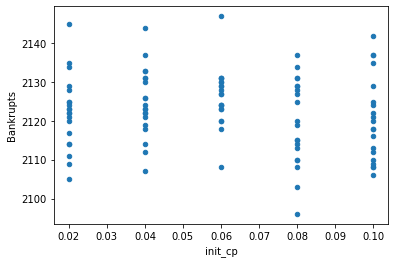

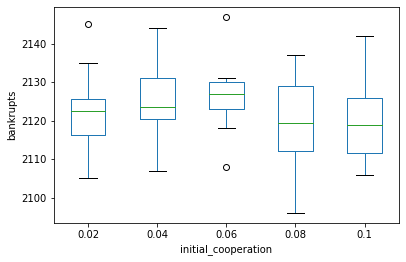

In [12]:
# modify the params of interest
init_rp=0
init_bp=0

# Run 
df = pd.DataFrame(columns=["init_cp", "Bankrupts"])

for i in range(1,6):
    init_coop = i/50
    bankrupts=batch_model(nsim=20, laststep=20)
    for item in bankrupts:
        df = df.append({"init_cp":init_coop, 'Bankrupts': item}, ignore_index=True)

#For further analysis, make a file.
#df.to_csv("abm_batch_running.csv")

#scatter plot
df.plot.scatter(x='init_cp', y='Bankrupts')

#box plot
ax = df.boxplot(by ='init_cp', column =['Bankrupts'], grid = False)
plt.title('')
plt.suptitle('')
ax.set_title('')
ax.set_xlabel("initial_cooperation")
ax.set_ylabel("bankrupts")
ax = plt.show()


Unclear relationship with the initial cooperation rate

##### Batch Simulation 2 - All Rational Players

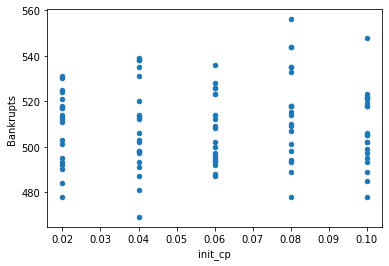

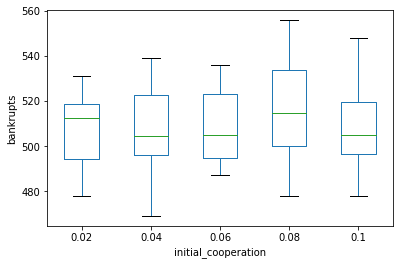

In [13]:
# modify the params of interest
init_rp=1

# Run 
df = pd.DataFrame(columns=["init_cp", "Bankrupts"])

for i in range(1,6):
    init_coop = i/50
    bankrupts=batch_model(nsim=20, laststep=20)
    for item in bankrupts:
        df = df.append({"init_cp":init_coop, 'Bankrupts': item}, ignore_index=True)

#For further analysis, make a file.
#df.to_csv("abm_batch_running.csv")

#scatter plot
df.plot.scatter(x='init_cp', y='Bankrupts')

#box plot
ax = df.boxplot(by ='init_cp', column =['Bankrupts'], grid = False)
plt.title('')
plt.suptitle('')
ax.set_title('')
ax.set_xlabel("initial_cooperation")
ax.set_ylabel("bankrupts")
ax = plt.show()

Again, unclear relationship between the initial cooperation rate and bankrupt

Some more tests on the code seems necessary.